# Keras for basic classification
Continuing from the last classification example, let's look at a more complicated case in which the classes are not linearly seperable.

We're going to require more than a single layer to solve this problem, so implementing a model in Numpy will become a bit complex; instead we'll switch to using Keras, which allows us to quickly build and train models of arbitrary size.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from keras.models import  Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
n = 200
r = np.linspace(0.1,5, n)+np.random.normal(scale=0.3, size=n)

In [3]:
t = np.linspace(-np.pi, np.pi, n)
x0 = np.array(list(zip(r*np.cos(t), r*np.sin(t), np.ones_like(t))))

In [4]:
t = np.linspace(0, 2*np.pi, n)
x1 = np.array(list(zip(r*np.cos(t), r*np.sin(t), np.zeros_like(t))))

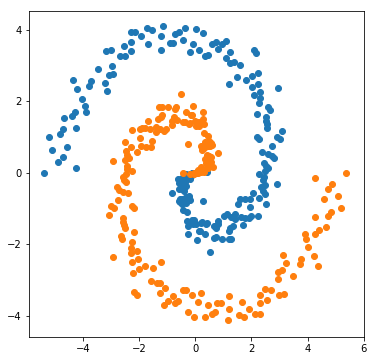

In [5]:
plt.figure(figsize=(6,6))
plt.scatter(x0[:,0], x0[:,1])
plt.scatter(x1[:,0], x1[:,1]);

Plotting the pseudodata in 2D space and using color indicate the class of the datapoints, we can see that no single straight line can be used to divide accurately the two classes. Instead we need some non-linear boundary to correctly predict the classes.

This could still be done using the Numpy-based neural network we had last time, however we'll need a few more neurons and several more layers than before, and working out all the derivatives manually would quickly become tiresome.

Instead we can use an autograd tensor library like Pytorch or Tensorflow, which will automatically compute the derivatives for us, as well as provide much quicker (accelerator backed) computation than Numpy can provide. However, workign directly with these libraries can be a steep learning curve. Instead we'll use Keras, which can act as a wrapper for a range of tensor libraries, providing an easy way to build, train, and apply neural networks.

In [6]:
d = np.vstack((x0, x1))
np.random.shuffle(d)

In [7]:
x = d[:,0:2]
y = d[:,2]

`x` are our inputs for the network - the position of the points in 2D space

`y` are the target for the network - the classes for the corresponding points

In [8]:
x[:10], y[:10]

(array([[-1.5358759 ,  0.88135837],
        [-2.38597046, -0.57580954],
        [-2.92945995,  2.77190777],
        [ 2.52599414,  1.44953512],
        [-0.6285544 , -0.16223178],
        [ 1.7814685 , -1.26024784],
        [ 2.17179197,  3.34234074],
        [-0.11393875, -1.30893676],
        [-4.25344868,  0.13434216],
        [-2.42704162,  0.19197617]]),
 array([0., 0., 1., 1., 1., 1., 1., 1., 1., 0.]))

Building a model in Keras can be done in two ways, the easiest is to instantiate a `Sequential` class and then add layers one after the other. Basic *fully connected* layers are created via the `Dense` class. For the first layer we need to tell it how many inputs to expect (2 in our case); subsequent layers automatically infer their input size. We can also add activation functions directly withing the Dense layer, or add them as layers themselves.

The activation functions we'll use are Rectified Linear Units (`ReLU`). This is basically $max\left(0,a\right)$, where $a$ is the input to the output of a neuron ($a=w\cdot x+b$). For such a simple function, it solves several problems that previous activation functions (sigmoid or $\tanh$) suffered; slow to evaluate and vanishing gradient.

Having constructed our model, it then needs to be 'compilied' to be actually used. This basically requires stating the optimiser we want and the loss function.

Previously, we used basic Gradient Descent, however this can be sometime slow to converge. Instead [Adam](https://arxiv.org/abs/1412.6980) will accumulate 'momentum' during updates allowing for faster movement down the gradient and will automatically scale the learning rate based on past gradients. Again it's normally quite a good default choice. 

In [9]:
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_normal'))  # Can add activate in Dense init
model.add(Dense(10, kernel_initializer='he_normal'))
model.add(Activation(activation='relu'))  # Or add activation as iwn layer after Dense (default act of Dense in None)
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy')

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


A Keras model generally follows the SKLearn conventions e.g. `.fit`, `.predict`. `x` are our inputs and `y` are the target values. Setting a `batch_size` means we used Stochastic Gradient Descent by using 'minibatches' samples without replacement from out training data. This means that each update is based only on a small subsample of the full data, meaning that the training is quicker, more robust against tuning the model to match the training data exactly (over-fitting), and still allows a more precise evaluation of the gradient than using single elements of the training data (with a batch size of 1).

Once all the training data has been used once, an 'epoch' has elapsed. Setting `epochs` means that training will finish once all the data has been used that many times.

In [11]:
history = model.fit(x=x, y=y, batch_size=64, epochs=25)

Epoch 1/25
400/400 [==============================] - 0s 483us/step - loss: 0.8184
Epoch 2/25
400/400 [==============================] - 0s 16us/step - loss: 0.6440
Epoch 3/25
400/400 [==============================] - 0s 21us/step - loss: 0.6213
Epoch 4/25
400/400 [==============================] - 0s 17us/step - loss: 0.5868
Epoch 5/25
400/400 [==============================] - 0s 19us/step - loss: 0.5794
Epoch 6/25
400/400 [==============================] - 0s 23us/step - loss: 0.5571
Epoch 7/25
400/400 [==============================] - 0s 18us/step - loss: 0.5474
Epoch 8/25
400/400 [==============================] - 0s 18us/step - loss: 0.5219
Epoch 9/25
400/400 [==============================] - 0s 19us/step - loss: 0.5102
Epoch 10/25
400/400 [==============================] - 0s 18us/step - loss: 0.4871
Epoch 11/25
400/400 [==============================] - 0s 21us/step - loss: 0.4629
Epoch 12/25
400/400 [==============================] - 0s 19us/step - loss: 0.4438
Epoch 13/25


The object returned by the fitting method contains a history of the training, which we can use to plot how the loss evolved overtime.

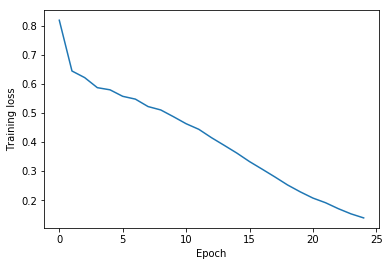

In [12]:
plt.plot(range(len(history.history['loss'])), history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel('Training loss');

In [13]:
preds = model.predict(x)

We can now see how well the model was able to identify the points.

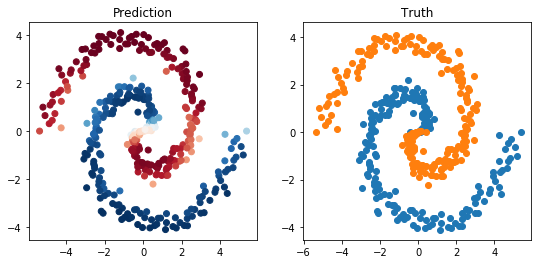

In [14]:
fig, axs = plt.subplots(1,2, figsize=(9,4))
axs[0].scatter(x[:,0], x[:,1], c=preds.squeeze(), cmap='RdBu_r')
axs[0].set_title('Prediction')
axs[1].scatter(x[y==0][:,0], x[y==0][:,1])
axs[1].scatter(x[y==1][:,0], x[y==1][:,1])
axs[1].set_title('Truth');

We could also see how the model would respond to data outside of what we used for training.

In [15]:
res = 50
a, b, pred_map = [], [], []

for i in np.linspace(x[:,0].min(), x[:,0].max(), res):
    x0 = i*np.ones((res,))
    x1 = np.linspace(x[:,1].min(), x[:,1].max(), res)
    pred_map += list(model.predict(np.array(list(zip(x0,x1)))).squeeze())
    a += list(x0)
    b += list(x1)

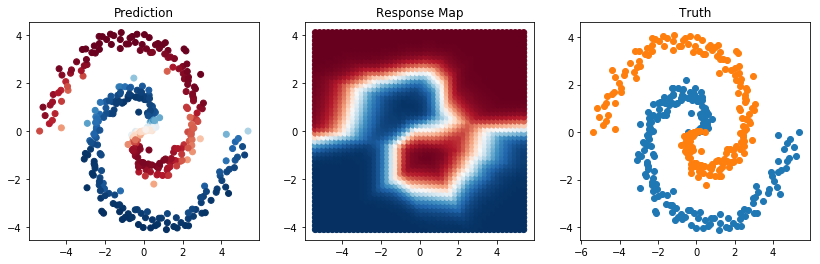

In [16]:
fig, axs = plt.subplots(1,3, figsize=(14,4))
axs[0].scatter(x[:,0], x[:,1], c=preds.squeeze(), cmap='RdBu_r')
axs[0].set_title('Prediction')
axs[1].scatter(a, b, c=pred_map, cmap='RdBu_r')
axs[1].set_title('Response Map')
axs[2].scatter(x[y==0][:,0], x[y==0][:,1])
axs[2].scatter(x[y==1][:,0], x[y==1][:,1])
axs[2].set_title('Truth');

Note how the response map indicates that the model does not try to extrapolate the spiral pattern, instead it would only work well for data similar to what saw during training, despite offering confident predictions in regions outside the training data. Neural networks are not magic or intelligent, just powerful tools.